<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
#!pip install ffn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 20.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

In [2]:
#Importing dependencies#
#from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


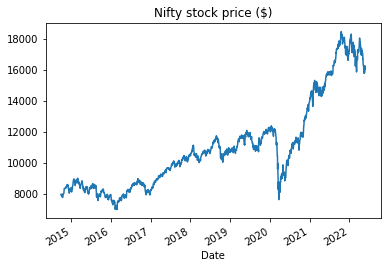

In [3]:
nifty_df = yf.download('^nsei',start='2014-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');

In [4]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)
nifty_df['30 Day MA'] = nifty_df['Close'].rolling(window=20).mean()

In [5]:
df = nifty_df[['Adj Close']]

Text(0.5, 0, 'Days')

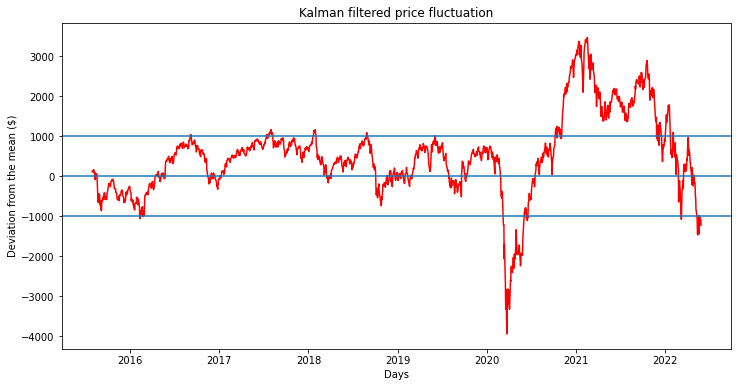

In [6]:
'''
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')
'''
mean=df['Adj Close'].rolling(window=200).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

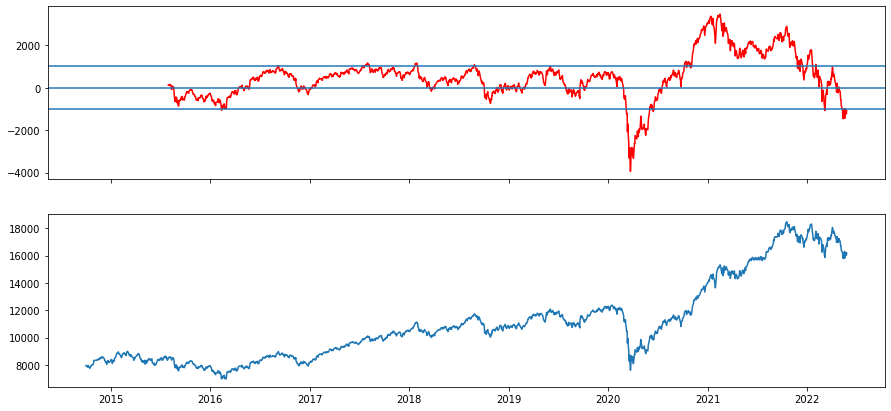

In [7]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax[0].plot(df['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].axhline(y=0)
ax[0].axhline(y=1000)
ax[0].axhline(y=-1000)
ax[1].plot(df['Adj Close'] , lw=1.5)

In [8]:
spread= pd.DataFrame({'Date':df.index,'spread':(df['Adj Close'].values - mean)})

In [9]:
spread=spread.set_index('Date')

In [10]:
df_new=pd.concat([df,spread['spread']],axis=1)


In [11]:
'''
SDev = 0.0
banda_supe = 0.0
banda_inf = 0.0
rapida = 26
lenta = 52
stdv = 0.8
m_rapida = ema(close,rapida)
m_lenta = ema(close,lenta)
BBMacd = m_rapida - m_lenta
Avg = ema(BBMacd,9)
SDev := stdev(BBMacd,9)
banda_supe := Avg + stdv * SDev
banda_inf := Avg - stdv * SDev
'''

'\nSDev = 0.0\nbanda_supe = 0.0\nbanda_inf = 0.0\nrapida = 26\nlenta = 52\nstdv = 0.8\nm_rapida = ema(close,rapida)\nm_lenta = ema(close,lenta)\nBBMacd = m_rapida - m_lenta\nAvg = ema(BBMacd,9)\nSDev := stdev(BBMacd,9)\nbanda_supe := Avg + stdv * SDev\nbanda_inf := Avg - stdv * SDev\n'

In [12]:
df_new['30 Day MA'] = df_new['spread'].rolling(window=50).mean()
# set .std(ddof=0) for population std instead of sample
df_new['30 Day STD'] = df_new['spread'].rolling(window=50).std() 
df_new['Upper Band'] = df_new['30 Day MA'] + (df_new['30 Day STD'] *2)
df_new['Lower Band'] = df_new['30 Day MA'] - (df_new['30 Day STD'] *2)
df_new['boll_percent'] = (df_new['spread']-df_new['Lower Band'])/(df_new['Upper Band']-df_new['Lower Band'])

In [13]:
df_new['30 Day MA'] = df_new['spread'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
df_new['30 Day STD'] = df_new['spread'].rolling(window=20).std() 
df_new['Upper Band'] = df_new['30 Day MA'] + (df_new['30 Day STD'] *2)
df_new['Lower Band'] = df_new['30 Day MA'] - (df_new['30 Day STD'] *2)
df_new['boll_percent'] = (df_new['spread']-df_new['Lower Band'])/(df_new['Upper Band']-df_new['Lower Band'])

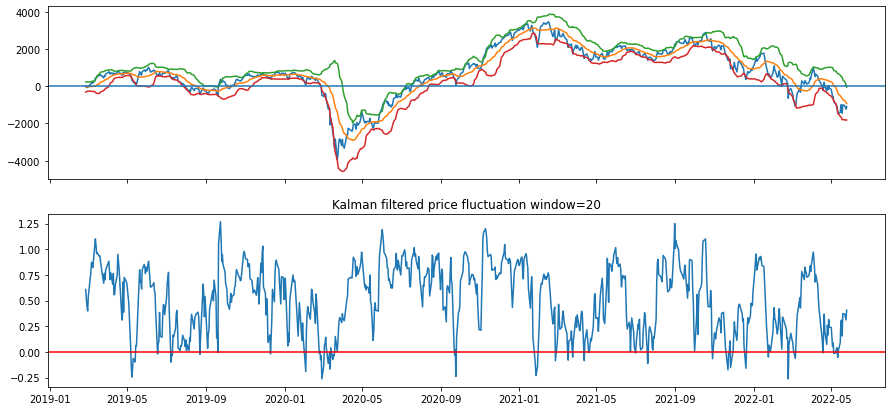

In [14]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-800:])
ax[0].axhline(y=0)
#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation window=20")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[1].plot(df_new[['boll_percent']][-800:])
ax[1].axhline(y=0,color='r')
plt.show()

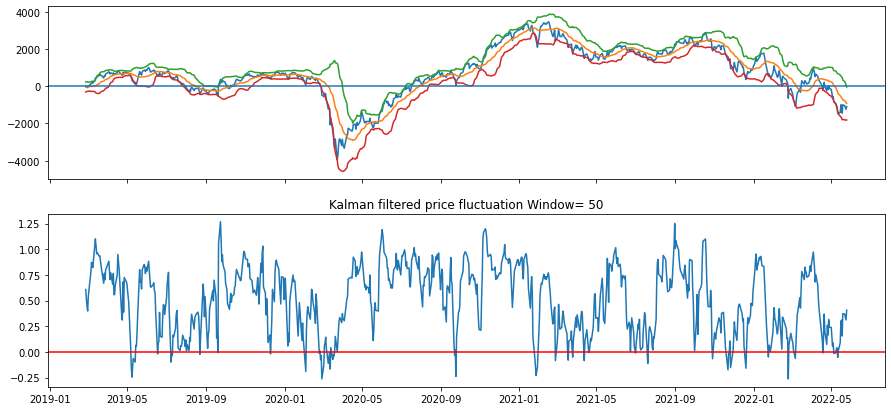

In [15]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-800:])
ax[0].axhline(y=0)
#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation Window= 50")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[1].plot(df_new[['boll_percent']][-800:])
ax[1].axhline(y=0,color='r')
plt.show()

In [16]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [17]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [18]:
nifty=nifty.set_index('date')

In [19]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2022-05-25,-1235.776182,-880.682360,470.350864,-645.506928,-1115.857792,-359.477331,-78.623360,-280.853972
2022-05-26,-1090.982349,-926.538772,441.643608,-705.716969,-1147.360576,-356.932655,-68.070401,-288.862254


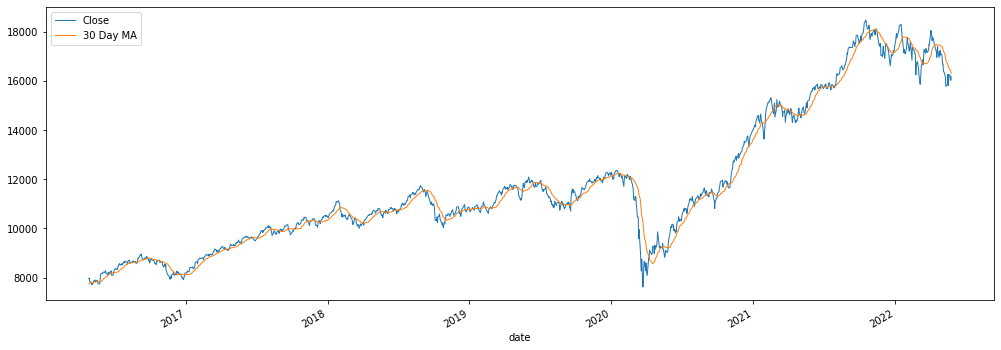

In [20]:
nifty_df[['Close','30 Day MA']][-1500:].plot(figsize=(17,6),linewidth=1);

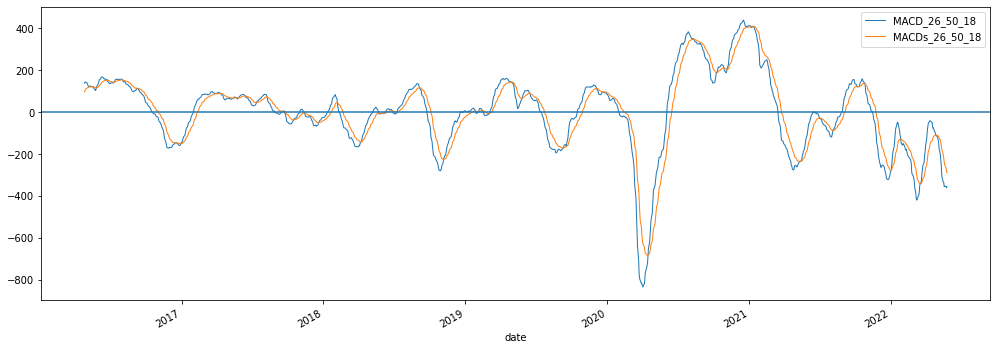

In [21]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1500:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

In [22]:
nifty['slope']=abs(nifty['MACD_26_50_18'].diff(5))
nifty['slope']=np.where(nifty['slope']<=10,0,nifty['slope'])
nifty['slope_s']=abs(nifty['MACDs_26_50_18'].diff(5))
nifty['slope_s']=np.where(nifty['slope_s']<=10,0,nifty['slope_s'])

In [23]:
nifty_df['Buy_ind'] = np.where((nifty['slope_s']>0), 1, 0)
#nifty['Sell_ind'] = np.where((nifty['slope_s']==-1), 0, 1)

In [24]:
l=-600

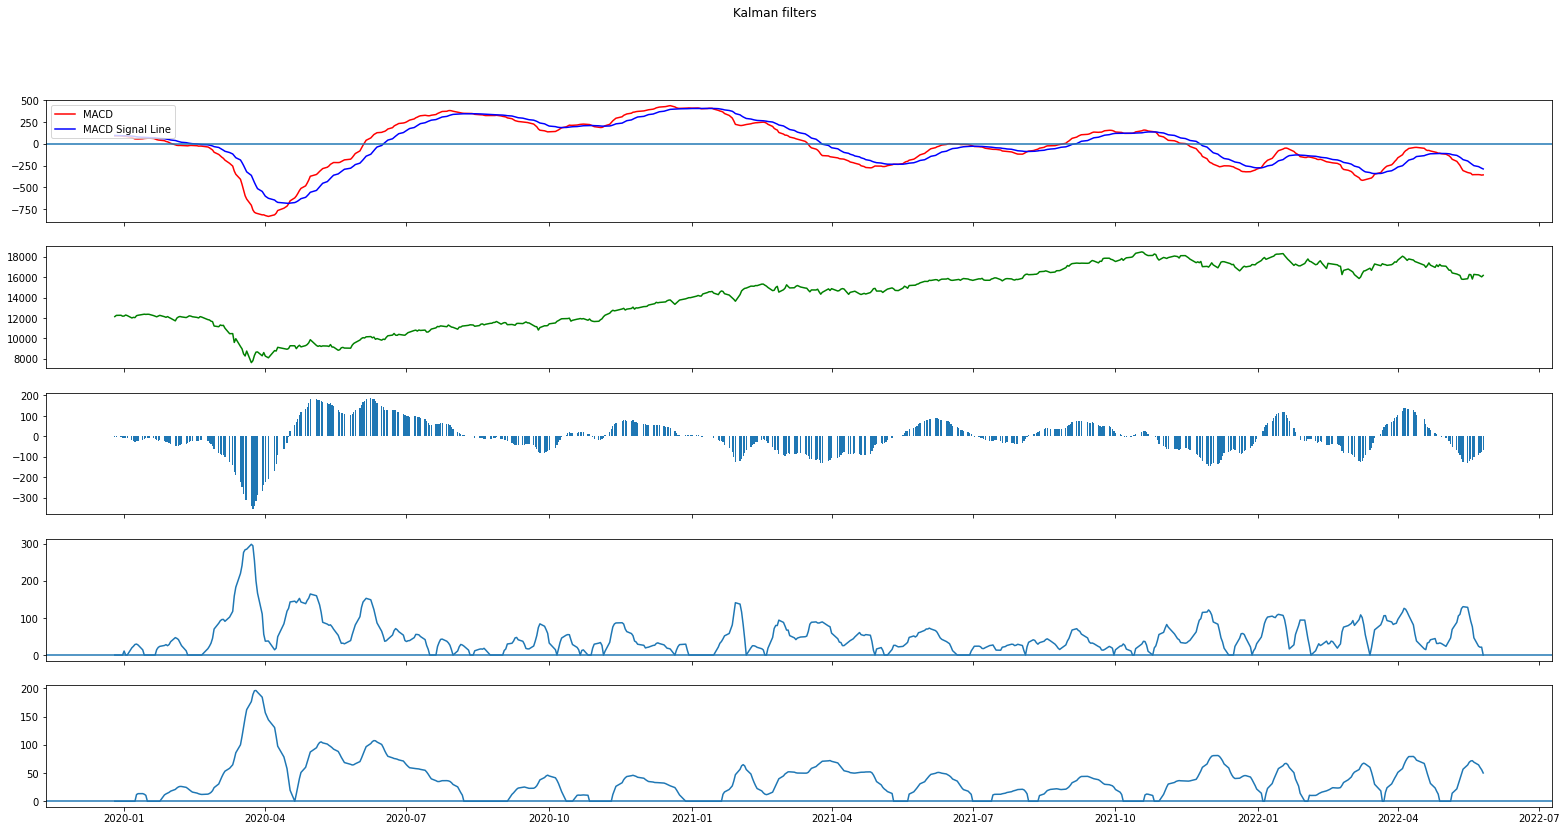

In [25]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACD_26_50_18'][l:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDs_26_50_18'][l:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDh_26_50_18'][l:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[l:], nifty_df.loc[:, 'Close'][l:],'g', label='NH moving avg 50 days')
#ax[1].scatter(nifty_df.loc[nifty_df['Buy_ind'] ==1,:].index[l:],nifty_df.loc[nifty_df['Buy_ind'] ==1,'Close'][l:] ,marker="*")
ax[3].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope'][l:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope_s'][l:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


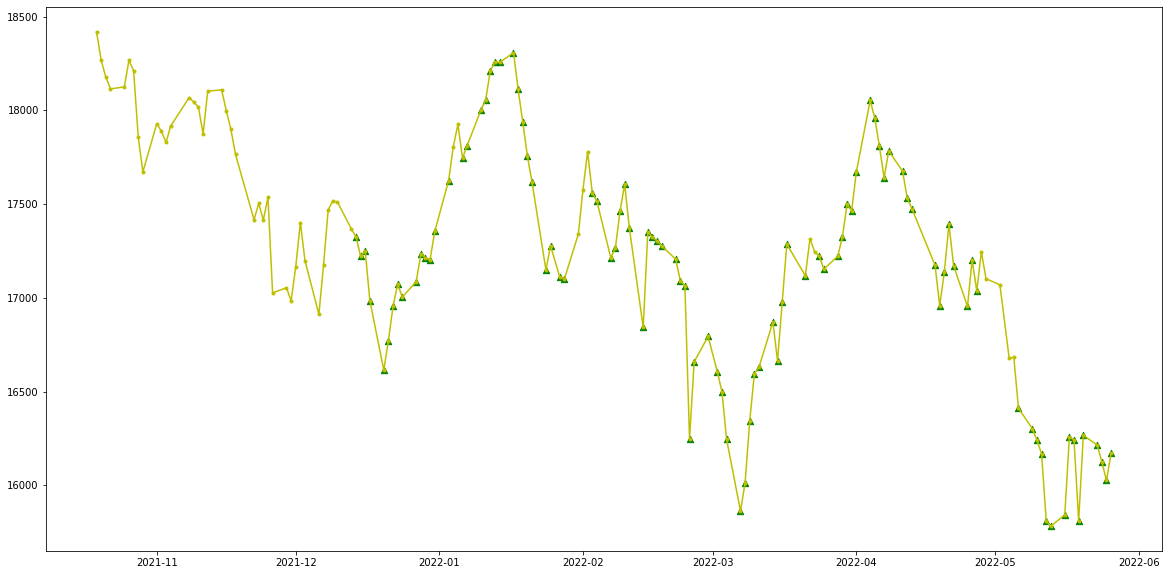

In [26]:
plt.figure(figsize=(20,10))
plt.plot(nifty_df.loc[:, :].index[-150:], nifty_df.loc[:, 'Close'][-150:],'y',marker='.')
plt.scatter(nifty_df.loc[nifty_df['Buy_ind'] ==1,:].index[-100:],nifty_df.loc[nifty_df['Buy_ind'] ==1,'Close'][-100:] ,marker="^",color='g',s=40)
#plt.scatter(nifty_df.loc[nifty_df['Buy_ind'] ==0,:].index[-1000:],nifty_df.loc[nifty_df['Buy_ind'] ==0,'Close'][-1000:] ,marker=".")

plt.show()

In [27]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,slope,slope_s
date,,,,,,,,,,
2022-05-26,-1090.982349,-926.538772,441.643608,-705.716969,-1147.360576,-356.932655,-68.070401,-288.862254,0.0,50.092148


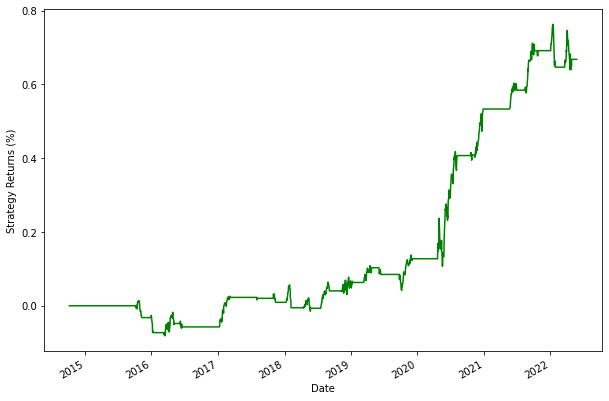

sharpe ratio :  0.040858445256433826
sortino ratio :  0.42059257458599547


In [28]:
nifty['sig']=np.where(nifty['MACDh_26_50_18']>0,1,-1)
nifty['sigs']=np.where(nifty['slope_s']>0,1,-1)
nifty['sigl']=nifty['sig']+nifty['sigs']
nifty['signals']=np.where(nifty['sigl']==2,1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

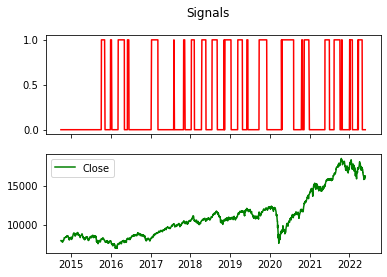

In [29]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


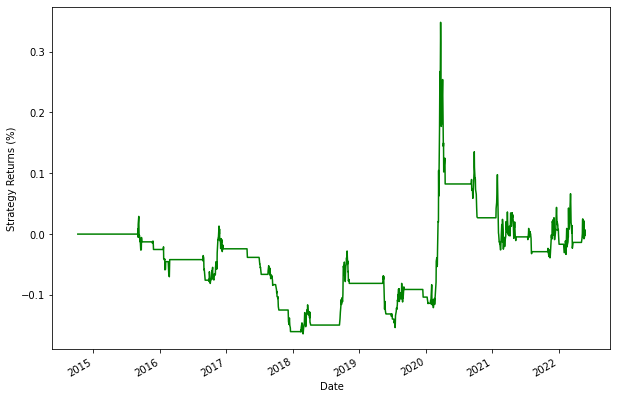

sharpe ratio :  -0.03738560877970577
sortino ratio :  -0.05146629897100363


In [30]:
nifty['sig_s']=np.where(nifty['MACDh_26_50_18']<0,-1,1)
nifty['sigs_s']=np.where(nifty['slope_s']>0,-1,1)
nifty['sigl_s']=nifty['sig_s']+nifty['sigs_s']
nifty['signals_s']=np.where(nifty['sigl_s']==-2,-1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals_s.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 